In [1]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt
import nltk  
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
def plot_accuracy_epoch(epochs,metric1,metric2):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, metric1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(epochs, metric2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training and Validation set losses')
    plt.show()

def plot_zoom(from_epoch,metric1,metric2):
    epochs_zoom = epochs[from_epoch:]
    metric1_zoom = metric1[from_epoch:]
    metric2_zoom = metric2[from_epoch:]

    plot_accuracy_epoch(epochs_zoom,metric1_zoom,metric2_zoom)  
    

def cleaned(text):
    text = re.sub(r"\n","",text)
    text = text.lower()
    text = re.sub(r"\d","",text)        #Remove digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text) # remove non-ascii
    text = re.sub(r'[^\w\s]','',text) #Remove punctuation
    text = re.sub(r'http\S+|www.\S+', '', text) #Remove http
    text = re.sub('[^a-zA-Z]', ' ', text) #replace non-letters with space 
    text = text.split()      
    text = [w for w in text if not w in set(stopwords.words('english'))] 
    text = ' '.join(text) 
    return text

seed=12

In [3]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
submission=pd.read_csv("sample_submission.csv")

In [4]:
train_data['cleaned'] = train_data['text'].apply(lambda x : cleaned(x))
test_data['cleaned'] = test_data['text'].apply(lambda x : cleaned(x))

train_features = train_data['cleaned'].to_numpy()
train_label = train_data['target'].to_numpy()
X_test = test_data['cleaned'].to_numpy()

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(train_features, train_label, test_size = 0.2, random_state = seed)

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 30 #max([max([len(i.split()) for i in X_test]), max([len(i.split()) for i in X_cv]), max([len(i.split()) for i in X_train])])
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [7]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(len(word_index))

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_cv)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

full_train_sequences = tokenizer.texts_to_sequences(train_features)
full_train_padded = pad_sequences(full_train_sequences, padding=padding_type, maxlen=max_length)

14674


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(6, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=1, min_lr=1e-5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 14)                238       
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 160,253
Trainable params: 160,253
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 5
history_nn=model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_cv),callbacks=[reduce_lr])

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 4s 608us/sample - loss: 0.6846 - accuracy: 0.5626 - val_loss: 0.6716 - val_accuracy: 0.5850
Epoch 2/5
6090/6090 [==============================] - 1s 91us/sample - loss: 0.6564 - accuracy: 0.6179 - val_loss: 0.6210 - val_accuracy: 0.6678
Epoch 3/5
6090/6090 [==============================] - 0s 80us/sample - loss: 0.5548 - accuracy: 0.7594 - val_loss: 0.5278 - val_accuracy: 0.7984
Epoch 4/5
6090/6090 [==============================] - 0s 82us/sample - loss: 0.4474 - accuracy: 0.8213 - val_loss: 0.4731 - val_accuracy: 0.8024
Epoch 5/5
6090/6090 [==============================] - 0s 77us/sample - loss: 0.3800 - accuracy: 0.8509 - val_loss: 0.4618 - val_accuracy: 0.7925


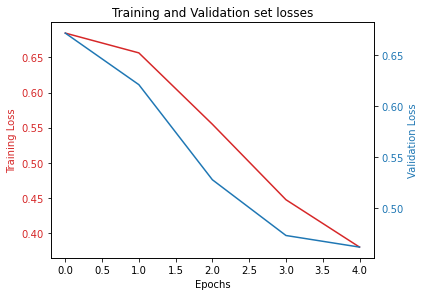

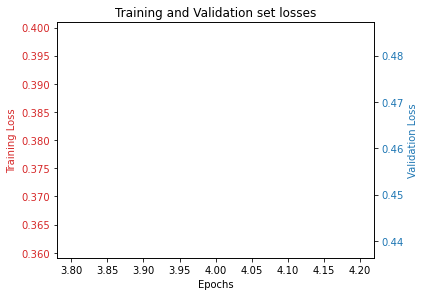

In [10]:
train_loss=history_nn.history['loss']
valid_loss=history_nn.history['val_loss']
epochs=range(len(train_loss))

plot_accuracy_epoch(epochs,train_loss,valid_loss)
plot_zoom(int(0.8*num_epochs),train_loss,valid_loss)

In [11]:
num_epochs = 5
history_nn=model.fit(full_train_padded, train_label, epochs=num_epochs)

Train on 7613 samples
Epoch 1/5
7613/7613 [==============================] - 0s 64us/sample - loss: 0.3626 - accuracy: 0.8497
Epoch 2/5
7613/7613 [==============================] - 0s 63us/sample - loss: 0.3255 - accuracy: 0.8702
Epoch 3/5
7613/7613 [==============================] - 0s 65us/sample - loss: 0.2979 - accuracy: 0.8803
Epoch 4/5
7613/7613 [==============================] - 0s 64us/sample - loss: 0.2785 - accuracy: 0.8901
Epoch 5/5
7613/7613 [==============================] - 0s 65us/sample - loss: 0.2564 - accuracy: 0.8973s - loss: 0.2684 - ac


In [12]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions = model.predict(testing_padded)
submission['target'] = (predictions > 0.5).astype(int)
submission.to_csv("submission.csv", index=False, header=True)